In [49]:
# Trabalho de PAA Análise da Eficiência Computacional e Desempenho de Técnicas de Seleção de Atributos em Modelos de Classificação para Dados MICS6 da Unicef
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
import warnings
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler


class GreedyFeatureSelector:
    # inicializa todos os atributos
    def __init__(self, models_config,
                patience=5, min_improvement=0.001, random_state=42):
        """
        Atributos disponíveis:
            models_config: dicionário com modelos e hiperparâmetros
            random_state: usar mesmo atributos de treino e teste 
            Critérios de parada: 
            patience: número de iterações sem melhoria antes de parar
            min_improvement: melhoria mínima necessária para continuar
        """
        self.models_config = models_config
        self.patience = patience
        self.min_improvement = min_improvement
        self.random_state = random_state
        
        self.selected_features = []
        self.best_score = -np.inf
        self.history = []
        self.best_model = None
        self.best_model_name = None
        self.feature_names = None
        
        # Armazenar dados para comparação
        self.train_features_resampled = None
        self.train_labels_resampled = None
        self.test_features_combined = None
        self.test_labels_combined = None
        
    # pré processamento adaptado do tcc 
    def preprocess_data(self, data_path):
        data = pd.read_csv(data_path)
        features = data

        # remover as linhas com idade igual 15, 16 ou 17 (os atributos estão vazios nessa idade)
        features = features[~features['fs_age'].isin([15, 16, 17])]

        # verifica desbalanceamento na classe principal 
        labels = np.array(features['sufferdiscplineviolence'])
        print("\nDistribuição das classes no conjunto completo:")
        print(pd.Series(labels).value_counts())

        # remove a coluna de rótulo
        features = features.drop('sufferdiscplineviolence', axis=1)
        self.feature_names = list(features.columns)

        # escalonar os dados
        scaler = StandardScaler()
        features = scaler.fit_transform(features)

        return features, labels

    
    #classe desbalanceada entre sofre e não sofre displina violenta
    def apply_undersampling(self, train_features, train_labels, test_features, test_labels):
        undersampling = RandomUnderSampler(random_state=self.random_state)
        train_features_resampled, train_labels_resampled = undersampling.fit_resample(train_features, train_labels)
        removed_indices = undersampling.sample_indices_
        removed_features = train_features[removed_indices]
        removed_labels = train_labels[removed_indices]
        
        # adicionar os valores descartados ao conjunto de teste ( para não descartar tudo )
        test_features_combined = np.vstack((test_features, removed_features))
        test_labels_combined = np.concatenate((test_labels, removed_labels))
        
        return train_features_resampled, train_labels_resampled, test_features_combined, test_labels_combined
    
    def evaluate_feature_subset(self, feature_indices, train_features, train_labels):
        best_score = -np.inf
        best_model = None
        best_model_name = None

        for model_name, config in self.models_config.items():
            model = config['model']

            X = train_features[:, feature_indices]
            y = train_labels

            cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=self.random_state)
            score = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1).mean()

            if score > best_score:
                best_score = score
                best_model = model
                best_model_name = model_name

        return best_model, best_model_name, best_score
    #método responsável pelo forward e backward
    def fit(self, data_path, mode='forward'):
        features, labels = self.preprocess_data(data_path)

        # dividir dados em treino e teste
        train_features, test_features, train_labels, test_labels = train_test_split(
            features, labels, test_size=0.2, random_state=self.random_state
        )
        train_features_resampled, train_labels_resampled, test_features_combined, test_labels_combined = \
            self.apply_undersampling(train_features, train_labels, test_features, test_labels)

        # armazenar dados para avaliação final
        self.train_features_resampled = train_features_resampled
        self.train_labels_resampled = train_labels_resampled
        self.test_features_combined = test_features_combined
        self.test_labels_combined = test_labels_combined

        iterations_without_improvement = 0
        self.history = []
        self.best_score = -np.inf
        
        # se for forward comeca com o array vazio e vai preenchendo variáveis um a uma até atingir critério de parada
        if mode == 'forward':
            self.selected_features = []
            remaining_features = list(range(len(self.feature_names)))

            print(f"forward com {len(self.feature_names)} atributos disponíveis...")

            while remaining_features:
                if iterations_without_improvement >= self.patience:
                    print(f"critério de parada atingido: {self.patience} iterações sem melhoria significativa.")
                    break

                print(f"\niteração {len(self.selected_features) + 1}")
                print(f"atributos selecionados: {len(self.selected_features)}")
                print(f"atributos restantes: {len(remaining_features)}")

                best_feature = None
                best_feature_score = -np.inf
                best_feature_model = None
                best_feature_model_name = None

                for i, feature_idx in enumerate(remaining_features):
                    current_features = self.selected_features + [feature_idx]
                    model, model_name, score = self.evaluate_feature_subset(
                        current_features, train_features_resampled, train_labels_resampled
                    )

                    print(f"  Feature {i+1}/{len(remaining_features)}: {self.feature_names[feature_idx][:30]:<30} "
                        f"Score: {score:.4f} (Modelo: {model_name})")

                    if score > best_feature_score:
                        best_feature_score = score
                        best_feature = feature_idx
                        best_feature_model = model
                        best_feature_model_name = model_name

                improvement = best_feature_score - self.best_score

                if improvement > self.min_improvement:
                    self.selected_features.append(best_feature)
                    remaining_features.remove(best_feature)
                    self.best_score = best_feature_score
                    self.best_model = best_feature_model
                    self.best_model_name = best_feature_model_name

                    self.history.append({
                        'iteration': len(self.selected_features),
                        'feature_added': self.feature_names[best_feature],
                        'feature_index': best_feature,
                        'score': self.best_score,
                        'improvement': improvement,
                        'model_used': best_feature_model_name,
                        'selected_features': [self.feature_names[idx] for idx in self.selected_features]
                    })

                    iterations_without_improvement = 0
                    print(f"\n✓ feature adicionada: {self.feature_names[best_feature]}")
                    print(f"  melhoria: {improvement:.4f}")
                else:
                    iterations_without_improvement += 1
                    print(f"\n✗ nenhuma melhoria significativa encontrada.")
                    print(f"  melhor score: {best_feature_score:.4f} | Melhoria: {improvement:.4f} (< {self.min_improvement})")
                    print(f"  iterações sem melhoria: {iterations_without_improvement}/{self.patience}")
        # se for backward pega todas os atributos inciais e vai removendo as que não garantem melhoria na acurácia
        elif mode == 'backward':
            self.selected_features = list(range(len(self.feature_names)))

            print(f"backward com {len(self.feature_names)} atributos disponíveis...")

            model, model_name, score = self.evaluate_feature_subset(
                self.selected_features, train_features_resampled, train_labels_resampled
            )
            self.best_score = score
            self.best_model = model
            self.best_model_name = model_name

            while len(self.selected_features) > 1:
                if iterations_without_improvement >= self.patience:
                    print(f"critério de parada atingido: {self.patience} iterações sem melhoria significativa.")
                    break

                print(f"\niteração {len(self.feature_names) - len(self.selected_features) + 1}")
                print(f"atributos selecionados: {len(self.selected_features)}")

                best_subset = None
                best_subset_score = -np.inf
                best_subset_model = None
                best_subset_model_name = None
                feature_removed = None

                for idx in self.selected_features:
                    current_subset = [f for f in self.selected_features if f != idx]

                    model, model_name, score = self.evaluate_feature_subset(
                        current_subset, train_features_resampled, train_labels_resampled
                    )

                    print(f" sem feature: {self.feature_names[idx][:30]:<30} Score: {score:.4f} (Modelo: {model_name})")

                    if score > best_subset_score:
                        best_subset_score = score
                        best_subset = current_subset
                        best_subset_model = model
                        best_subset_model_name = model_name
                        feature_removed = idx

                improvement = best_subset_score - self.best_score

                if improvement > self.min_improvement:
                    self.selected_features = best_subset
                    self.best_score = best_subset_score
                    self.best_model = best_subset_model
                    self.best_model_name = best_subset_model_name

                    self.history.append({
                        'iteration': len(self.feature_names) - len(self.selected_features),
                        'feature_removed': self.feature_names[feature_removed],
                        'feature_index': feature_removed,
                        'score': self.best_score,
                        'improvement': improvement,
                        'model_used': best_subset_model_name,
                        'remaining_features': [self.feature_names[idx] for idx in self.selected_features]
                    })

                    iterations_without_improvement = 0
                    print(f"\n✓ feature removida: {self.feature_names[feature_removed]}")
                    print(f"  melhoria: {improvement:.4f}")
                else:
                    iterations_without_improvement += 1
                    print(f"\n✗ nenhuma melhoria significativa encontrada.")
                    print(f"  melhor score: {best_subset_score:.4f} | melhoria: {improvement:.4f} (< {self.min_improvement})")
                    print(f"  iterações sem melhoria: {iterations_without_improvement}/{self.patience}")

        print("\n" + "=" * 80)
        print(f"sELEÇÃO DE ATRIBUTOS CONCLUÍDA ({mode.upper()})")
        print(f"atributos finais: {len(self.selected_features)}")
        print(f"score final: {self.best_score:.4f}")
        print(f"modelo final: {self.best_model_name}")

        return self.selected_features, self.best_score, self.history, self.best_model

    # método inicial que utiliza todos os atributos sem seleção gulosa
    def evaluate_all_features(self):
        print(f"número total de atributos: {len(self.feature_names)}")
        print(f"atributos: {self.feature_names}")
        
        all_features_results = {}
        
        for model_name, config in self.models_config.items():
            print(f"avaliando modelo: {model_name}")
            
            model = config['model']
            cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=self.random_state)
            
            # validação cruzada com 10 folds
            scores = cross_val_score(model, self.train_features_resampled, self.train_labels_resampled, 
                                    scoring='accuracy', cv=cv, n_jobs=-1)
            mean_cv_score = scores.mean()
            
            print(f"Score médio de validação cruzada: {mean_cv_score:.4f}")
            
            # treina o modelo com todos os dados de treino
            model.fit(self.train_features_resampled, self.train_labels_resampled)
            
            #predições no conjunto de teste
            test_predictions = model.predict(self.test_features_combined)
            
            # calcula métricas
            accuracy = accuracy_score(self.test_labels_combined, test_predictions)
            precision_0 = precision_score(self.test_labels_combined, test_predictions, pos_label=0)
            precision_1 = precision_score(self.test_labels_combined, test_predictions, pos_label=1)
            recall_0 = recall_score(self.test_labels_combined, test_predictions, pos_label=0)
            recall_1 = recall_score(self.test_labels_combined, test_predictions, pos_label=1)
            f1_0 = f1_score(self.test_labels_combined, test_predictions, pos_label=0)
            f1_1 = f1_score(self.test_labels_combined, test_predictions, pos_label=1)
            conf_matrix = confusion_matrix(self.test_labels_combined, test_predictions)
        
            #resultados
            all_features_results[model_name] = {
                'model_name': model_name,
                'model': model,
                'cv_score': mean_cv_score,
                'accuracy': accuracy,
                'precision_0': precision_0,
                'precision_1': precision_1,
                'recall_0': recall_0,
                'recall_1': recall_1,
                'f1_0': f1_0,
                'f1_1': f1_1,
                'confusion_matrix': conf_matrix
            }
            
            print(f"\nmétricas no conjunto de teste:")
            print(f"  acuracia: {accuracy:.4f}")
            print(f"  precisão (Classe 0 - sem displ violenta): {precision_0:.4f}")
            print(f"  precisão (Classe 1 - com displ violenta): {precision_1:.4f}")
            print(f"  recall (Classe 0 - sem displ violenta): {recall_0:.4f}")
            print(f"  recall (Classe 1 - com displ violenta): {recall_1:.4f}")
            print(f"  F1 Score (Classe 0 - sem displ violenta): {f1_0:.4f}")
            print(f"  F1 Score (Classe 1 - com displ violenta): {f1_1:.4f}")
            print(f"  Confusion Matrix:\n{conf_matrix}")
        
        return all_features_results
    #método que compara gulosa e normal
    def compare_greedy_vs_all_features(self):

        # retorna os dois modelos
        all_features_results = self.evaluate_all_features()
        
        if all_features_results is None:
            return None
        greedy_metrics = self.evaluate_final_model()
        print("COMPARAÇÃO: SELEÇÃO GULOSA vs TODAS OS ATRIBUTOS")
        
        # encontrar o melhor modelo com todas os atributos
        best_all_features_model = max(all_features_results.keys(), 
                                     key=lambda x: all_features_results[x]['f1_1'])
        best_all_features_results = all_features_results[best_all_features_model]
        
        print(f"\n{'SELEÇÃO GULOSA':<25} | {'TODO OS ATRIBUTOS':<25}")
        print("-" * 53)
        print(f"{'modelo:':<25} | {'modelo:':<25}")
        print(f"{self.best_model_name:<25} | {best_all_features_model:<25}")
        print(f"{'atributos:':<25} | {'atributos:':<25}")
        print(f"{len(self.selected_features):<25} | {len(self.feature_names):<25}")
        print(f"{'CV Score:':<25} | {'CV Score:':<25}")
        print(f"{self.best_score:<25.4f} | {best_all_features_results['cv_score']:<25.4f}")
        print(f"{'acuracia:':<25} | {'acuracia:':<25}")
        print(f"{greedy_metrics['accuracy']:<25.4f} | {best_all_features_results['accuracy']:<25.4f}")
        print(f"{'precisão (Classe 1):':<25} | {'precisão (Classe 1):':<25}")
        print(f"{greedy_metrics['precision_1']:<25.4f} | {best_all_features_results['precision_1']:<25.4f}")
        print(f"{'recall (Classe 1):':<25} | {'recall (Classe 1):':<25}")
        print(f"{greedy_metrics['recall_1']:<25.4f} | {best_all_features_results['recall_1']:<25.4f}")
        print(f"{'F1 Score (Classe 1):':<25} | {'F1 Score (Classe 1) :':<25}")
        print(f"{greedy_metrics['f1_1']:<25.4f} | {best_all_features_results['f1_1']:<25.4f}")
        
        print(f"\atributos selecionados pela abordagem gulosa:")
        for i, feature_idx in enumerate(self.selected_features):
            print(f"  {i+1}. {self.feature_names[feature_idx]}")
    
        f1_improvement = greedy_metrics['f1_1'] - best_all_features_results['f1_1']
        accuracy_improvement = greedy_metrics['accuracy'] - best_all_features_results['accuracy']
        feature_reduction = len(self.feature_names) - len(self.selected_features)
        
        return {
            'greedy_metrics': greedy_metrics,
            'all_features_results': all_features_results,
            'best_all_features_model': best_all_features_model,
            'feature_reduction': feature_reduction,
            'f1_improvement': f1_improvement,
            'accuracy_improvement': accuracy_improvement
        }
    

    #  modelo final no conjunto de teste.
    def evaluate_final_model(self):
        test_features_selected = self.test_features_combined[:, self.selected_features]
        train_features_selected = self.train_features_resampled[:, self.selected_features]
        model = clone(self.best_model)
        model.fit(train_features_selected, self.train_labels_resampled)
        test_predictions = model.predict(test_features_selected)
        accuracy = accuracy_score(self.test_labels_combined, test_predictions)
        precision_0 = precision_score(self.test_labels_combined, test_predictions, pos_label=0)
        precision_1 = precision_score(self.test_labels_combined, test_predictions, pos_label=1)
        recall_0 = recall_score(self.test_labels_combined, test_predictions, pos_label=0)
        recall_1 = recall_score(self.test_labels_combined, test_predictions, pos_label=1)
        f1_0 = f1_score(self.test_labels_combined, test_predictions, pos_label=0)
        f1_1 = f1_score(self.test_labels_combined, test_predictions, pos_label=1)
        conf_matrix = confusion_matrix(self.test_labels_combined, test_predictions)

        metrics = {
            'accuracy': accuracy,
            'precision_0': precision_0,
            'precision_1': precision_1,
            'recall_0': recall_0,
            'recall_1': recall_1,
            'f1_0': f1_0,
            'f1_1': f1_1,
            'confusion_matrix': conf_matrix
        }

        return metrics
    # imprime resultados da seleção gulosa
    def print_results(self):
        print(f"\natributos selecionados ({len(self.selected_features)}):")
        for i, feature_idx in enumerate(self.selected_features):
            print(f"  {i+1}. {self.feature_names[feature_idx]}")
        print(f"\nmelhor modelo: {self.best_model_name}")
        print(f"score de validação cruzada: {self.best_score:.4f}")
        # avalia no conjunto de teste
        metrics = self.evaluate_final_model()
        if metrics:
            print(f"\nmétricas no conjunto de teste:")
            print(f"  acuracia: {metrics['accuracy']:.4f}")
            print(f"  precisão (Classe 0 - sem displ violenta): {metrics['precision_0']:.4f}")
            print(f"  precisão (Classe 1 - com displ violenta): {metrics['precision_1']:.4f}")
            print(f"  recall (Classe 0 - sem displ violenta): {metrics['recall_0']:.4f}")
            print(f"  recall (Classe 1 - com displ violenta): {metrics['recall_1']:.4f}")
            print(f"  F1 Score (Classe 0 - sem displ violenta): {metrics['f1_0']:.4f}")
            print(f"  F1 Score (Classe 1 - com displ violenta): {metrics['f1_1']:.4f}")
            print(f"  Confusion Matrix:\n{metrics['confusion_matrix']}")


In [50]:
from sklearn.neighbors import KNeighborsClassifier
#modelo base é o knn
models_config = {
   'KNN': {
        'model': KNeighborsClassifier(n_neighbors=5),
        'param_grid': None 
    }
}

In [51]:
#executa forward
selector_forward = GreedyFeatureSelector(
    models_config=models_config,
    patience=5,
    min_improvement=0.0001,
    random_state=42
)
selector_forward.fit('dataset_sem_outliers.csv', mode="forward")



========================= FORWARD SELECTION =========================

Distribuição das classes no conjunto completo:
0    126295
1     71090
Name: count, dtype: int64
Seleção Gulosa (Forward) com 69 features disponíveis...

Iteração 1
Atributos selecionados: 0
Atributos restantes: 69
  Feature 1/69: Population                     Score: 0.5000 (Modelo: KNN)
  Feature 2/69: Area                           Score: 0.5000 (Modelo: KNN)
  Feature 3/69: GDP per Capita                 Score: 0.5000 (Modelo: KNN)
  Feature 4/69: Fertility Rate                 Score: 0.5000 (Modelo: KNN)
  Feature 5/69: Female Life Expectancy         Score: 0.5000 (Modelo: KNN)
  Feature 6/69: Male Life Expectancy           Score: 0.5000 (Modelo: KNN)
  Feature 7/69: Infant Mortality Rate          Score: 0.5000 (Modelo: KNN)
  Feature 8/69: sex                            Score: 0.5000 (Modelo: KNN)
  Feature 9/69: father_education_level         Score: 0.5000 (Modelo: KNN)
  Feature 10/69: FCD2D                

([39,
  0,
  30,
  47,
  53,
  43,
  29,
  18,
  4,
  3,
  49,
  2,
  33,
  67,
  64,
  54,
  52,
  63,
  5,
  6,
  14,
  41],
 0.7594068094068095,
 [{'iteration': 1,
   'feature_added': 'num_hh_members',
   'feature_index': 39,
   'score': 0.5002281502281501,
   'improvement': inf,
   'model_used': 'KNN',
   'selected_features': ['num_hh_members']},
  {'iteration': 2,
   'feature_added': 'Population',
   'feature_index': 0,
   'score': 0.501860301860302,
   'improvement': 0.0016321516321518015,
   'model_used': 'KNN',
   'selected_features': ['num_hh_members', 'Population']},
  {'iteration': 3,
   'feature_added': 'FCD2J',
   'feature_index': 30,
   'score': 0.5137241137241138,
   'improvement': 0.011863811863811802,
   'model_used': 'KNN',
   'selected_features': ['num_hh_members', 'Population', 'FCD2J']},
  {'iteration': 4,
   'feature_added': 'fs_age',
   'feature_index': 47,
   'score': 0.580967005967006,
   'improvement': 0.06724289224289226,
   'model_used': 'KNN',
   'selected_

In [ ]:
import io
import sys

captura = io.StringIO()
stdout_original = sys.stdout
sys.stdout = captura
selector_forward.print_results()
sys.stdout = stdout_original
texto_print_results = captura.getvalue()
results_forward = selector_forward.compare_greedy_vs_all_features()
texto_results_forward = str(results_forward)

# salva resultados no arquivo ---
with open("resultado_forward.txt", "w", encoding="utf-8") as f:
    f.write(texto_print_results)
    f.write(texto_results_forward)

In [53]:
#executa backward
selector_backward = GreedyFeatureSelector(
    models_config=models_config,
    patience=5,
    min_improvement=0.0001,
    random_state=42
)
selector_backward.fit('dataset_sem_outliers.csv', mode="backward")


========================= BACKWARD ELIMINATION =========================

Distribuição das classes no conjunto completo:
0    126295
1     71090
Name: count, dtype: int64
Eliminação Reversa (Backward) com 69 features disponíveis...

Iteração 1
Atributos selecionados: 69
  Sem feature: Population                     Score: 0.7437 (Modelo: KNN)
  Sem feature: Area                           Score: 0.7448 (Modelo: KNN)
  Sem feature: GDP per Capita                 Score: 0.7448 (Modelo: KNN)
  Sem feature: Fertility Rate                 Score: 0.7452 (Modelo: KNN)
  Sem feature: Female Life Expectancy         Score: 0.7450 (Modelo: KNN)
  Sem feature: Male Life Expectancy           Score: 0.7450 (Modelo: KNN)
  Sem feature: Infant Mortality Rate          Score: 0.7455 (Modelo: KNN)
  Sem feature: sex                            Score: 0.7471 (Modelo: KNN)
  Sem feature: father_education_level         Score: 0.7456 (Modelo: KNN)
  Sem feature: FCD2D                          Score: 0.7447 (M

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  13,
  14,
  18,
  23,
  27,
  29,
  30,
  32,
  33,
  36,
  37,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  47,
  49,
  52,
  53,
  55,
  58,
  59,
  62,
  64,
  65,
  66,
  67,
  68],
 0.7591260091260091,
 [{'iteration': 1,
   'feature_removed': 'hh_mobile_phone',
   'feature_index': 11,
   'score': 0.7474903474903474,
   'improvement': 0.0021411021411020803,
   'model_used': 'KNN',
   'remaining_features': ['Population',
    'Area',
    'GDP per Capita',
    'Fertility Rate',
    'Female Life Expectancy',
    'Male Life Expectancy',
    'Infant Mortality Rate',
    'sex',
    'father_education_level',
    'FCD2D',
    'mother_relationship_head',
    'fs_wears_glass_lens',
    'remember_disab',
    'hh_computer',
    'number_of_disabled_domains',
    'MA1',
    'mental_disorder_signs',
    'child_needs_punish',
    'anxiety_disab',
    'depression_disab',
    'be_understood_disab',
    'learn_disab',
    'num_women_15_49',
    

In [ ]:
captura = io.StringIO()
stdout_original = sys.stdout
sys.stdout = captura
selector_backward.print_results()
sys.stdout = stdout_original
texto_print_results = captura.getvalue()
results_backward = selector_backward.compare_greedy_vs_all_features()
texto_results_backward = str(results_backward)

# salva resultados no arquivo ---
with open("resultado_backward.txt", "w", encoding="utf-8") as f:
    f.write(texto_print_results)
    f.write(texto_results_backward)

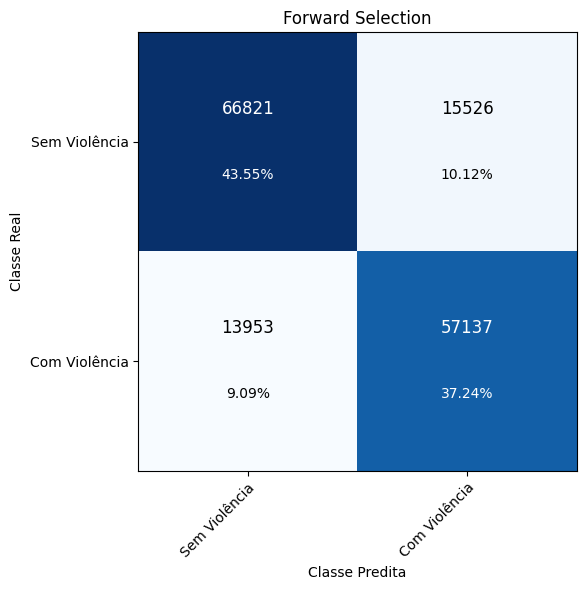

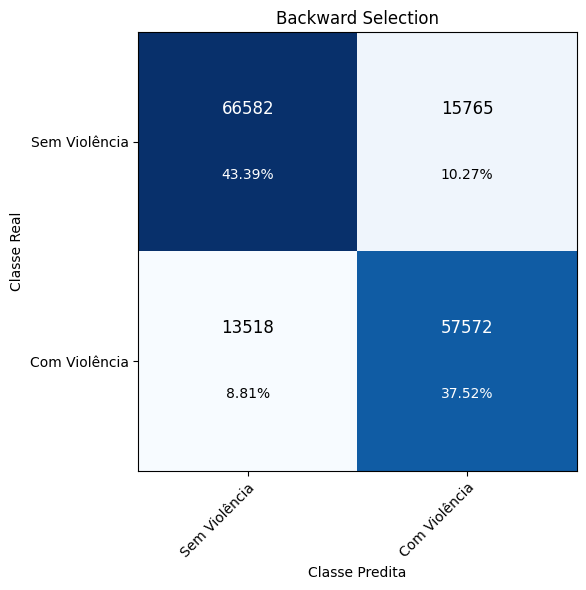

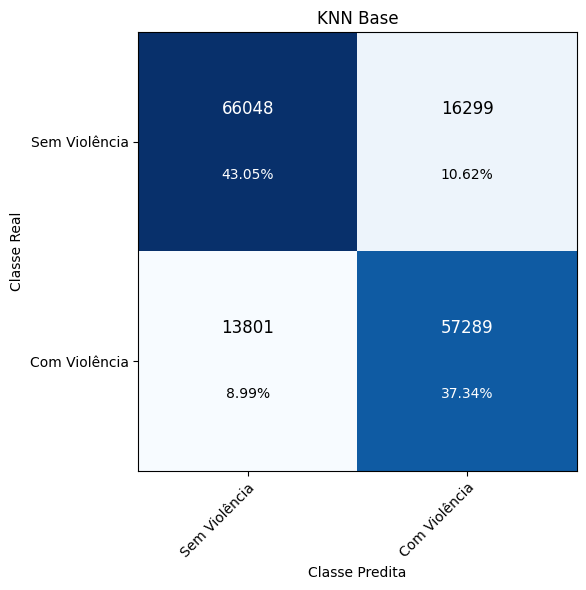

In [1]:
#imprime a matriz de confusão
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# matriz forward
cm_forward = np.array([[66821, 15526],
                       [13953, 57137]])
# matriz backward
cm_backward = np.array([[66582, 15765],
                        [13518, 57572]])
#matriz baseline
cm_base = np.array([[66048, 16299],
                    [13801, 57289]])

labels = ['Sem Violência', 'Com Violência']
matrizes = [cm_forward, cm_backward, cm_base]
titles = ['Forward Selection', 'Backward Selection', 'KNN Base']

for cm, title in zip(matrizes, titles):
    total = cm.sum()
    fig, ax = plt.subplots(figsize=(6, 6))

    cmap = plt.cm.Blues
    norm = matplotlib.colors.Normalize(vmin=cm.min(), vmax=cm.max())
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            perc = val / total * 100
            
            rgba = cmap(norm(val))
            luminance = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
            text_color = 'white' if luminance < 0.5 else 'black'
            
            ax.text(j, i - 0.15, f'{val}', ha='center', va='center', color=text_color, fontsize=12)
            ax.text(j, i + 0.15, f'{perc:.2f}%', ha='center', va='center', color=text_color, fontsize=10)

    ax.set_title(title)
    ax.set_xlabel('Classe Predita')
    ax.set_ylabel('Classe Real')

    plt.tight_layout()
    plt.show()
